# Laboratorio 2 - Perceptrón para clasificar lirios - Práctica 1

Grupo B07

- Álvaro Ramos Morales

- Álvaro Delgado Gallego

- Fernando Ramírez Fernández

- Juan Esteban Bernal Santos

In [1]:
# Se importan las librerías necesarias para el desarrollo de la práctica
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, make_scorer
from tabulate import tabulate
from sklearn.metrics import confusion_matrix

C:\Users\Fer\AppData\Local\Temp\ipykernel_23500\2797913174.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Estudio del dataset Iris

In [2]:
# Cargamos el conjunto de datos de iris
iris = load_iris()
X, y = iris.data, iris.target

# Ver las primeras 5 filas de datos
print("\nPrimeras 5 filas de datos:")
print(iris.data[:5])

# Ver las etiquetas de las clases
print("\nEtiquetas de las clases:")
print(iris.target_names)

# Ver la descripción del conjunto de datos
print("\nDescripción del conjunto de datos:")
print(iris.DESCR)






Primeras 5 filas de datos:
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

Etiquetas de las clases:
['setosa' 'versicolor' 'virginica']

Descripción del conjunto de datos:
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76  

In [3]:
class Perceptron:
    def __init__(self, learning_rate=0.1, threshold=0.1, n_iter=300):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.n_iter = n_iter
        self.weights = None  # Inicializar con None, se establecerá en fit
        self.bias = None
        self.history = []
    
    def activate(self, x):
        return np.where(x >= self.threshold, 1, 0)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.rand(n_features)  # Inicialización aleatoria de pesos
        self.bias = 0  # Inicialización aleatoria del sesgo
        reached_max_accuracy = False

        for epoch in range(self.n_iter):
            accuracy = accuracy_score(y, self.predict(X))
            epoch_history = {'Epoch': epoch + 1, 'Updates': [], 'Accuracy': accuracy}
            if accuracy == 1 and not reached_max_accuracy:
                reached_max_accuracy = True
            elif reached_max_accuracy and accuracy == 1:
                self.history.append(epoch_history)
                break  # Finaliza después de una época extra después de alcanzar accuracy de 1

            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activate(linear_output)
                update = self.learning_rate * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

                # Ahora guarda todas las instancias procesadas, independientemente del valor de update
                epoch_history['Updates'].append({
                    'Inputs': x_i.tolist(),
                    'Desired output': y[idx],
                    'Actual output': y_predicted,
                    'Error': y[idx] - y_predicted,
                    'Initial weights': self.weights.tolist(),
                    'Final weights': (self.weights + update * x_i).tolist()
                })
            self.history.append(epoch_history)
            
    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activate(linear_output)
        return y_predicted

In [4]:
# Función para graficar puntos de distinto color para cada tipo de lirio
def plot_iris_data(X, y):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', legend='full')
    plt.xlabel('Longitud del sépalo')
    plt.ylabel('Anchura del sépalo')
    plt.title('Distribución de los tipos de lirio')
    plt.grid(True)
    plt.show()

In [5]:
#Funcion dibujar hiperplano
def plot_hyperplane(X, y, weights, bias):
    # Asegurar que la pendiente 'm' y la intercepción 'b' sean escalares
    m = -weights[0] / weights[1]
    b = -bias / weights[1] if isinstance(bias, np.ndarray) else -bias / weights[1]
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='Set1', legend='full')
    plt.xlabel('Longitud del pétalo')
    plt.ylabel('Anchura del pétalo')
    plt.title('Distribución de los tipos de lirio')
    plt.grid(True)
    
    x_hyperplane = np.linspace(0, 8, 10)
    y_hyperplane = m * x_hyperplane + b
    plt.plot(x_hyperplane, y_hyperplane, color='black')

    # Asegurarse de que los valores pasados a la cadena de formato son escalares
    m_text = m.item() if isinstance(m, np.ndarray) else m
    b_text = b.item() if isinstance(b, np.ndarray) else b
    
    plt.figtext(0.5, 0.01, f'y = {m_text:.2f}x + {b_text:.2f}', fontsize=12, ha='center')
    plt.show()

# Ejemplo de uso:
# plot_hyperplane(X, y, perceptron.weights, perceptron.bias)


## Cuestión 1

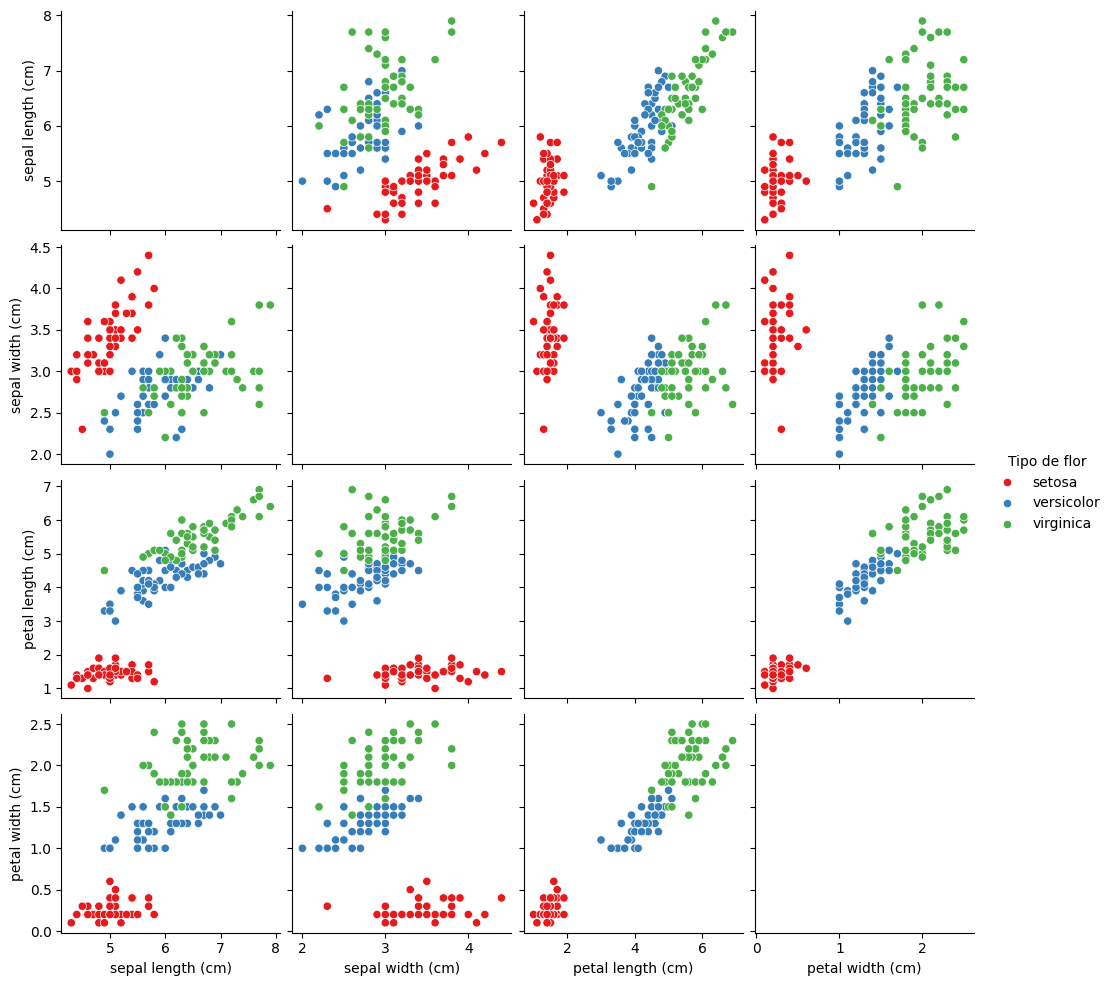

In [6]:
feature_names = iris.feature_names

# Creamos un DataFrame para facilitar la visualización
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['Tipo de flor'] = y
species_names = {0: 'setosa', 1: 'versicolor', 2: 'virginica'}
iris_df['Tipo de flor'] = iris_df['Tipo de flor'].map(species_names)

# Generamos gráficas de dispersión para cada par de atributos
g = sns.pairplot(iris_df, hue='Tipo de flor', palette='Set1', diag_kind='None')

plt.show()


Debido a la relación observada entre cada par de variables dentro del dataset, se determina que el par más adecuado para la clasificación es el de "petal length" (longitud del pétalo) con "petal width" (anchura del pétalo). Esta selección se basa en varias consideraciones: la combinación de "petal length" y "petal width" muestra una distinción más notoria entre las tres clases de flores (setosa, versicolor y virginica) en comparación con otros pares de variables, lo que significa que estas dos características tienen la capacidad de separar eficazmente las diferentes clases de flores en el espacio de características. 

Además, al observar los valores de las características dentro de cada clase, se nota que "petal length" y "petal width" exhiben patrones de comportamiento más similares dentro de una misma clase, lo que los hace más consistentes y distintivos para cada tipo de flor

In [7]:
#cogemos petal length y petal width
X = iris.data[:,(2,3)]  # Tomamos los dos atributos con mayor relevancia para la clasificación



#Cojemos solo las plantas de tipo setosa y virginica
X = X[(y == 0) | (y == 2)]
y = y[(y == 0) | (y == 2)]



#X = iris.data[:,(2,3)]  # Tomamos los dos atributos con mayor relevancia para la clasificación
#Convertir las etiquetas de las clases a 0 y 1
y = np.where(y == 0, 0, 1)


#Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [8]:
# Definir los hiperparámetros para el grid search
learning_rates = [0.01, 0.1, 0.5]
thresholds = [0.01, 0.2, 0.75]

results_list = []

# Crear gridsearch y recoger historial
for lr in learning_rates:
    for th in thresholds:
        perceptron = Perceptron(learning_rate=lr, threshold=th)
        perceptron.fit(X_train, y_train)
        y_pred = perceptron.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Agregar los resultados a la lista
        results_list.append({
            'Learning Rate': lr,
            'Threshold': th,
            'Accuracy': accuracy
        })

# Convertir la lista de resultados en un DataFrame
results_df = pd.DataFrame(results_list)

# Mostrar información de overfitting
perceptron = Perceptron(learning_rate=lr, threshold=th)
perceptron.fit(X_train, y_train)
y_pred_train = perceptron.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
y_pred_test = perceptron.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy en entrenamiento: {accuracy_train:.2f}')
print(f'Accuracy en prueba: {accuracy_test:.2f}')

# Guardar el DataFrame en un archivo CSV
results_df.to_csv('resultados_perceptron1.csv', index=False)

# Mostrar los resultados usando la tabla del paquete tabulate (opcional)
from tabulate import tabulate
print(tabulate(results_df, headers='keys', tablefmt='psql'))



Accuracy en entrenamiento: 1.00
Accuracy en prueba: 1.00
+----+-----------------+-------------+------------+
|    |   Learning Rate |   Threshold |   Accuracy |
|----+-----------------+-------------+------------|
|  0 |            0.01 |        0.01 |       1    |
|  1 |            0.01 |        0.2  |       1    |
|  2 |            0.01 |        0.75 |       1    |
|  3 |            0.1  |        0.01 |       1    |
|  4 |            0.1  |        0.2  |       1    |
|  5 |            0.1  |        0.75 |       1    |
|  6 |            0.5  |        0.01 |       0.95 |
|  7 |            0.5  |        0.2  |       1    |
|  8 |            0.5  |        0.75 |       1    |
+----+-----------------+-------------+------------+


## Cuestión 2

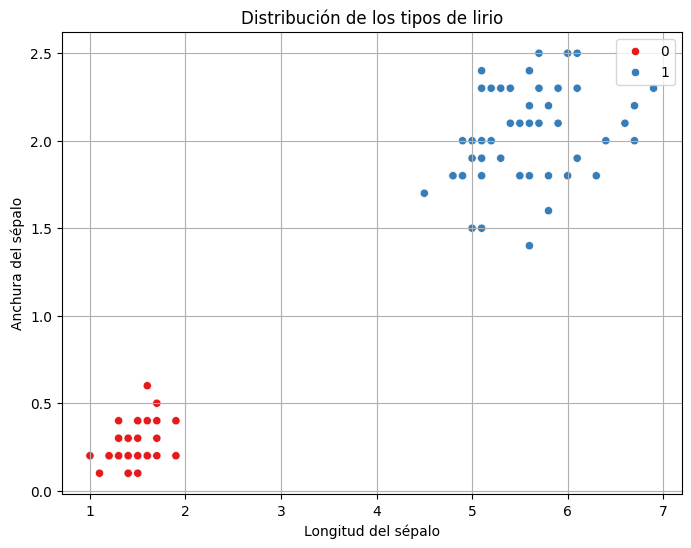

In [9]:
# Graficamos la distribución de los tipos de lirio
plot_iris_data(X, y)

In [10]:
print("Pesos del perceptrón:", perceptron.weights)
print("Umbral del perceptrón:", perceptron.bias)

Pesos del perceptrón: [0.26550551 0.68936806]
Umbral del perceptrón: -1.5


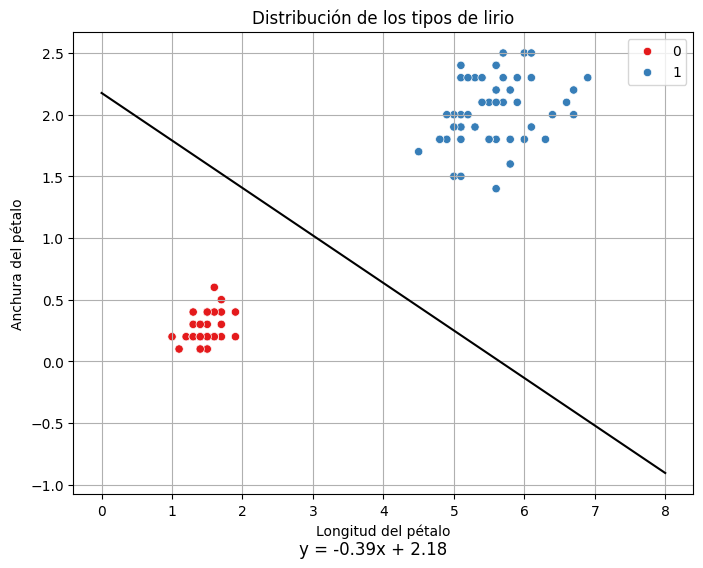

In [11]:
# Graficamos el hiperplano resultante
plot_hyperplane(X, y, perceptron.weights, perceptron.bias)

## Cuestión 3

In [12]:
#cogemos petal length,petal width y sepal length
x3 = iris.data[:,(2,3,0)]
y3 = iris.target

#Cogemos 4 atributos
x4 = iris.data[:,(0,1,2,3)]  # Tomamos los dos atributos con mayor relevancia para la clasificación
y4 = iris.target

#PAsamos las etiquetas de las clases a 0 y 1
y3 = np.where(y3 == 0, 0, 1)
y4 = np.where(y4 == 0, 0, 1)


#Cogemos solo virgínica y setosa para 3
x3 = x3[(y3 == 0) | (y3 == 2)]
y3 = y3[(y3 == 0) | (y3 == 2)]

#Cogemos solo setosa y virginica para 4
x4 = x4[(y4 == 0) | (y4 == 2)]
y4 = y4[(y4 == 0) | (y4 == 2)]



#Dividir el conjunto de datos en entrenamiento y prueba
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, random_state=42)
X_train4, X_test4, y_train4, y_test4 = train_test_split(x4, y4, test_size=0.2, random_state=42)


#Entrenamos el perceptrón
perceptron3 = Perceptron(learning_rate=0.01, threshold=0.01)
perceptron3.fit(X_train3, y_train3)
perceptron4 = Perceptron(learning_rate=0.01, threshold=0.01)
perceptron4.fit(X_train4, y_train4)

#Accuary con3 y 4 atributos
y_pred_train3 = perceptron3.predict(X_train3)
accuracy_train3 = accuracy_score(y_train3, y_pred_train3)
y_pred_test3 = perceptron3.predict(X_test3)
accuracy_test3 = accuracy_score(y_test3, y_pred_test3)
y_pred_train4 = perceptron4.predict(X_train4)
accuracy_train4 = accuracy_score(y_train4, y_pred_train4)
y_pred_test4 = perceptron4.predict(X_test4)
accuracy_test4 = accuracy_score(y_test4, y_pred_test4)

print(f'Accuracy en entrenamiento con 3 atributos: {accuracy_train3:.2f}')
print(f'Accuracy en prueba con 3 atributos: {accuracy_test3:.2f}')
print(f'Accuracy en entrenamiento con 4 atributos: {accuracy_train4:.2f}')
print(f'Accuracy en prueba con 4 atributos: {accuracy_test4:.2f}')

#Imprimimos los pesos y el umbral del perceptrón
print("Pesos del perceptrón con 3 atributos:", perceptron3.weights)
print("Umbral del perceptrón con 3 atributos:", perceptron3.bias)
print("Pesos del perceptrón con 4 atributos:", perceptron4.weights)
print("Umbral del perceptrón con 4 atributos:", perceptron4.bias)


Accuracy en entrenamiento con 3 atributos: 1.00
Accuracy en prueba con 3 atributos: 1.00
Accuracy en entrenamiento con 4 atributos: 1.00
Accuracy en prueba con 4 atributos: 1.00
Pesos del perceptrón con 3 atributos: [ 0.44326234  0.14602495 -0.187125  ]
Umbral del perceptrón con 3 atributos: -0.19000000000000003
Pesos del perceptrón con 4 atributos: [-0.01655383 -0.38825165  0.64988315  0.83824098]
Umbral del perceptrón con 4 atributos: -0.18000000000000002


Hacemos la matriz de confusión para la cuestión 2 de la prática 2

In [13]:
# Hacemos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)


Matriz de confusión:
[[12  0]
 [ 0  8]]
